In [1]:
import json
import datetime as dt
from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, get_month_names
import locale
import slugify

# math packages:
import pandas as pd
import numpy as np
from math import pi

# charting:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib.ticker import MultipleLocator
import seaborn as sns

# images and display
from IPython.display import Markdown as md
from IPython import display

# Plastock - Iqaasl

In [2]:
# plastock data
plastock = pd.read_csv("data/20230314macro.csv", sep=";", encoding="ISO-8859-3")
p_beaches = pd.read_csv("data/asl_beaches2.csv")
# iqaasl data
iq_dims = pd.read_csv("data/corrected_dims.csv")
iqaasl = pd.read_csv("data/lac_leman_iqaasl.csv")

# plastock survey data of interest
pstck_cols = ['Lieu', 'Aire','Position', 'Date', 'Code', 'Quantité']
pstck_rename = {"Lieu":"location", "Aire":"area", "Date":"date", "Code":"code", "Quantité":"quantity", "Position":"position"}
pstck =  plastock[pstck_cols]
pstck = pstck.rename(columns=pstck_rename)

# the surveys were separated into two zones for plastock
# we want to compare the total of the surveys, so the zones at each
# location and survey need to be combined
pstck_q = pstck.groupby(["location", "date", "code"], as_index=False).quantity.sum()

# the length of the survey is not included in the plastock survey data
# it needs to be attached to the survey reults, this information is available
# in the beaches file
pbl = p_beaches[["location", "length"]].drop_duplicates(["location", "length"]).set_index("location")

# the dimensional data was taken once per survey
# remove the duplicate values by date and location
pstck_ndup = pstck.drop_duplicates(["location", "date","area"])
# combine the areas by date and location
pstck_ta = pstck_ndup.groupby(["location", "date"]).area.sum()
pstck = pstck_q.merge(pstck_ta, on=["location", "date"])

# the location names in asl_beaches does not match the names in 20230314macro.csv
# the names in the asl_beaches file were changed previously
# they need to be changed back to match the new survey data
p_names = sorted(p_beaches.location.unique())
pstock_names = sorted(plastock.Lieu.unique())

# the differences are capitalizations and hyphenations
renames = {x: p_names[i] for i, x in enumerate(pstock_names)}
pstck["location"] = pstck.location.apply(lambda x: renames[x])

# add the length
pstck["length"] = pstck.location.apply(lambda x: pbl.loc[x].length)
pstck["project"] = "plastock"
pstck["date"] = pd.to_datetime(pstck["date"], format="%d.%m.%Y")

pstck["doy"] = pstck["date"].dt.dayofyear
pstck["date"] = pstck["date"].dt.date

# the columns of interest
survey_columns = [
    "location",
    "date",
    "code",
    "length",
    "area",
    "quantity",
    "project",
    "doy"
]

pstck = pstck[survey_columns]
# there are aggregations that need to be made to the plastock data. The fragemented foams
# and fragmented plastics are consolidated into one group of codes. The plastic caps are consolidated
# as per the intend of the ASL and the recomendation from the IQAASL report.    
gfoam = ["G81", "G82", "G83"]
plasticpcs = [ "G78", "G79", "G80", "G75", "G76", "G77"]
Gcaps = [ "G21", "G23", "G24" ]

# the columns that are being kept and the operations per column          
columns = ['location', 'date', 'area', 'length','project', "doy"]
operations = {"quantity":"sum"}

# separate the codes of interest by group from the data frame and add the replacement value
pstck_gfrags = pstck[pstck.code.isin(plasticpcs)].groupby(columns, as_index=False).agg(operations)
pstck_gfoam = pstck[pstck.code.isin(gfoam)].groupby(columns, as_index=False).agg(operations)
pstck_gcaps = pstck[pstck.code.isin(Gcaps)].groupby(columns, as_index=False).agg(operations)

pstck_gcaps["code"] = "Gcaps"
pstck_gfoam["code"] = "Gfoam"
pstck_gfrags["code"] = "Gfrags"

# remove the same instances from the work data                                                               
pstck_no_frags = pstck[~pstck.code.isin([*plasticpcs, *gfoam, *Gcaps])].copy()

# formatted plastock data
pstck = pd.concat([pstck_no_frags, pstck_gfrags, pstck_gfoam, pstck_gcaps])

# zero is not accounted for in the plastock data
# this is essential for computing the median and average
# values. The fail rate can not be calculated with out it
# 1. collect all the codes that were identified in plastock
codes = pstck.code.unique()

# 2 make a dataframe of all possible codes and give them a
# quantity of zero
code_zero = pd.DataFrame({"code":codes})
code_zero["quantity"] = 0

# 3. collect all the unique date and location pairs
dates = pstck[['date', 'location']].drop_duplicates()

def add_zeroes(data, dates, code_zero):
    
    some_zeroes = []
    for apair in dates.values:
        # collect the results from one survey
        d = data[(data.location == apair[1])&(data["date"] == apair[0])]
        # collect the codes that were identified in the current survey
        codes_with_vals = d.code.unique()
        # identify the codes that were not identified
        codes_with_no_vals = [x for x in code_zero.code.unique() if x not in codes_with_vals]
        # collect the area and length for the current survey
        area_length = d[["area", "length"]].drop_duplicates(["area", "length"]).reset_index()
        # add the area, length, location, date and project to
        # to the dataframe of codes and zeroes
        code_zero["area"] = area_length.loc[0, "area"]
        code_zero["length"] = area_length.loc[0, "length"]
        code_zero["date"] = apair[0]
        code_zero["location"] = apair[1]
        code_zero["project"] = "plastock"
        # keep only the codes that were not indentified in the survey
        test_no_vals = code_zero[code_zero.code.isin(codes_with_no_vals)]
        # add the resulting df to the list
        some_zeroes.append(test_no_vals)
    return some_zeroes

# collect the zero values
zeroes =  add_zeroes(pstck, dates, code_zero)
# add them to the existing survey results
pstk = pd.concat([pstck, *zeroes], axis=0)

# IQAASL data
# only locations on lac leman
iq_locations = iqaasl.location.unique()
iq_d = iq_dims[iq_dims.location.isin(iq_locations)]

# there are three surveys that do not have length or area data:
# two at quai-maria-belgia and one at baby-plage-geneva
# the average value of the preceeding surveys will be used
qmb = iq_d[(iq_d.location == "quai-maria-belgia") & (iq_d.area > 0)].agg({"length":"mean", "area":"mean"})
bp = iq_d[(iq_d.location == "baby-plage-geneva") & (iq_d.area > 0)].agg({"length":"mean", "area":"mean"})

# separate the surveys with no dimensional data
qmb_0 = iq_d[(iq_d.location == "quai-maria-belgia") & (iq_d.area == 0)]
bp_0 = iq_d[(iq_d.location == "baby-plage-geneva") & (iq_d.area == 0)]

# add the derived values
qmb_0.loc[:, "area"] = qmb.area
qmb_0.loc[:, "length"] = qmb.length
bp_0.loc[:, "area"] = bp.area
bp_0.loc[:, "length"] = bp.length

# merge the corrections with the original data
# minus the records with no diemensional data
iqd = iq_d[(iq_d.area > 0)]
iqd = pd.concat([iqd, qmb_0, bp_0], axis=0)
iqd_la = iqd[["loc_date", "area"]].set_index("loc_date")

iqaasl["project"] = "iqaasl"
iqaasl["area"] = iqaasl.loc_date.apply(lambda x: iqd_la.loc[x].area)
iqa = iqaasl.copy()
iqa["date"] = pd.to_datetime(iqa["date"])
iqa["doy"] = iqa["date"].dt.dayofyear
iqa["date"] = iqa["date"].dt.date
iqa = iqa[survey_columns].copy()
iqa = iqa[iqa.code.isin(codes)]

# make gcaps, gfrags and foams are ready made
iqaasl_not_caps = iqa[~iqa.code.isin(Gcaps)].copy()
iqaasl_caps = iqa[iqa.code.isin(Gcaps)].groupby(columns, as_index=False).quantity.sum()
iqaasl_caps["code"] = "Gcaps"

# formatted iqaasl data
iqa = pd.concat([iqaasl_caps, iqaasl_not_caps])
combined = pd.concat([iqa,pstk], axis=0).reset_index(drop=True)
combined["loc_date"] = list(zip(combined.location, combined["date"]))
combined["pcs/m"] = combined["quantity"]/combined["length"]
combined["pcs/m²"] = combined["quantity"]/combined["area"]

combined_dt = combined.groupby(["loc_date", "location", "date", "doy", "project", "area", "length"], as_index=False).agg({"pcs/m":"sum", "pcs/m²":"sum"})

In [3]:
combined_dt.groupby("project")["area"].describe()

,count,mean,std,min,25%,50%,75%,max
project,,,,,,,,
iqaasl,98.0,209.444388,166.092656,3.0,117.75,159.0,260.25,942.0
plastock,95.0,430.126316,409.095974,16.0,231.00,340.0,496.00,1978.0


In [4]:
combined_dt.groupby("project")["length"].describe()

,count,mean,std,min,25%,50%,75%,max
project,,,,,,,,
iqaasl,98.0,48.051215,27.862933,5.0,29.25,43.625544,56.0,157.0
plastock,95.0,69.168421,32.032116,18.0,45.00,66.000000,91.0,125.0


In [5]:
summary_parea = combined_dt.groupby("project")["pcs/m²"].describe()
summary_parea

,count,mean,std,min,25%,50%,75%,max
project,,,,,,,,
iqaasl,98.0,2.265950,4.245064,0.026217,0.427429,0.975176,2.160528,32.333333
plastock,95.0,0.688491,0.674213,0.025974,0.200222,0.520588,0.877902,3.637168


In [6]:
summary_pm = combined_dt.groupby("project")["pcs/m"].describe()
summary_pm

,count,mean,std,min,25%,50%,75%,max
project,,,,,,,,
iqaasl,98.0,7.289342,10.449068,0.157303,1.757353,3.733333,7.791667,58.500000
plastock,95.0,3.612734,3.729718,0.100000,0.786041,2.481481,4.833142,18.681818


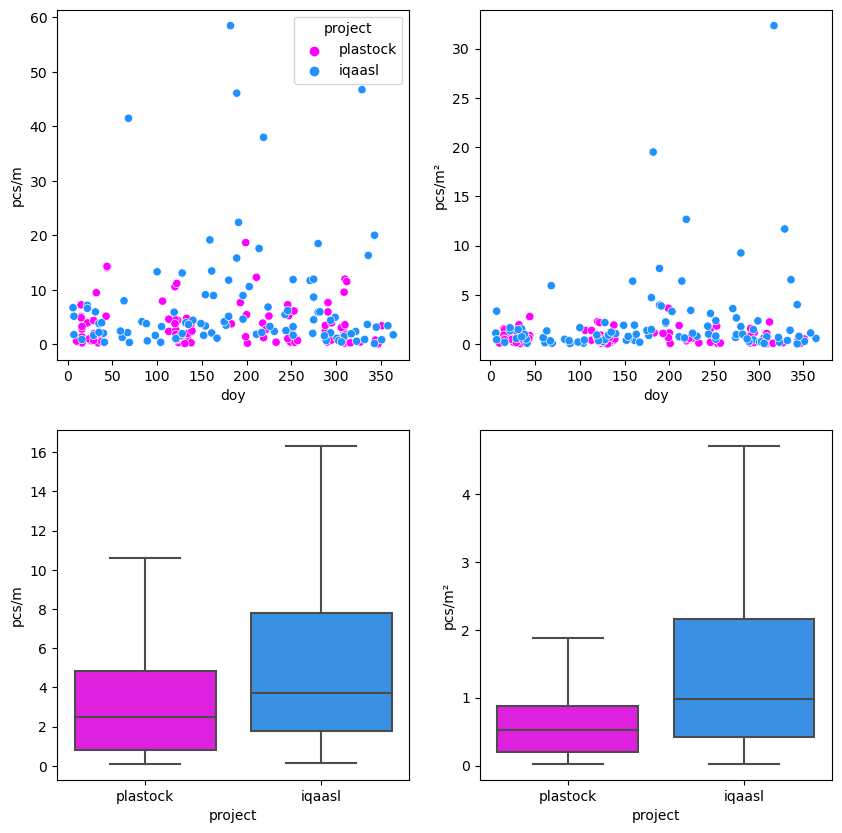

In [7]:
fig, ax = plt.subplots(2,2, figsize=(10, 10))
palette= {"iqaasl":"dodgerblue", "plastock":"magenta"}

sns.scatterplot(data=combined_dt, x="doy", y="pcs/m", ax=ax[0,0], hue="project", palette=palette)
sns.scatterplot(data=combined_dt, x="doy", y="pcs/m²", ax=ax[0,1], hue="project", palette=palette)
sns.boxplot(data=combined_dt, x='project', y="pcs/m", ax=ax[1,0], hue="project", palette=palette, showfliers=False, dodge=False)
sns.boxplot(data=combined_dt, x='project', y="pcs/m²", ax=ax[1,1], hue="project", palette=palette, showfliers=False, dodge=False)


for anax in [ax[0,1], ax[1,0], ax[1,1]]:
    anax.get_legend().remove()


plt.show()

In [8]:
# fail rate


def n_fails(data, code, threshhold=0):
    
    return ((data.code == code) & (data.quantity > threshhold)).sum()
    

def fail_rate(data, code, threshhold=0, project="iqaasl"):
    d = data[data.project == project]
    fails = n_fails(d, code, threshhold=threshhold)
    tries = d.loc_date.nunique()
    
    return fails/tries

def make_fail_rate_df(data, codes, project="iqaasl", threshold=0):
    
    results = []
    
    for code in codes:
        results.append({"code":code, "project":project, "fail rate":fail_rate(data, code, project=project)})
    
    return pd.DataFrame(results)

iqa_fail_rate = make_fail_rate_df(combined, codes)
pstk_fail_rate = make_fail_rate_df(combined, codes, project='plastock')

fail_rates = pd.concat([iqa_fail_rate, pstk_fail_rate], axis=0)

fail_rates = fail_rates.pivot(index="code", columns="project")
fail_rates.sort_values(by=("fail rate","iqaasl"), ascending=False)[:20]


fail rate          
project    iqaasl  plastock
code                       
Gfrags   0.969388  0.968421
G30      0.959184  0.736842
G27      0.948980  0.800000
Gfoam    0.836735  0.736842
G95      0.816327  0.547368
G74      0.775510  0.378947
G67      0.775510  0.084211
G35      0.734694  0.410526
G89      0.663265  0.315789
G31      0.663265  0.557895
G32      0.632653  0.242105
G100     0.612245  0.094737
G33      0.571429  0.178947
G25      0.551020  0.042105
G70      0.520408  0.400000
G10      0.510204  0.094737
G112     0.469388  0.368421
G211     0.438776  0.410526
G66      0.418367  0.305263
G73      0.397959  0.063158